# Examine tuning patterns of model hidden units

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
import torch

from trajectory import TrajectoryParams, TrajectoryGenerator
from model import ModelHyperParams, PathRNN

from ratemaps import compute_ratemaps, plot_ratemaps

## Load model

In [2]:
# Path where model is loaded from
MODEL_FPATH = 'models/test_2022_04_26.pt'


# TODO: Load these from model! 
model_hparams = ModelHyperParams()

In [3]:
model = PathRNN(model_hparams)
model.load_state_dict(torch.load(MODEL_FPATH))
model.eval();

## Ratemaps

### Run model on simulation and compute ratemaps

In [4]:
# Use trajectory generator with default parameters
traj_params = TrajectoryParams()
tgen = TrajectoryGenerator(traj_params)

# Compute ratemaps
activations, pos, h = compute_ratemaps(model, tgen)

### Plot ratemaps

(-0.5, 379.5, 139.5, -0.5)

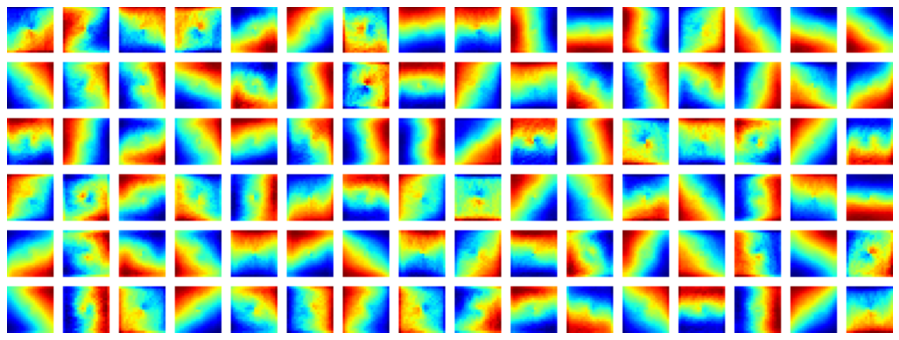

In [5]:
# Plot all cells
n_plot = model.hparams.n_units

# Figure size
plt.figure(figsize=(16, 4 * n_plot // 8**2))

# Ratemap plot
rm_fig = plot_ratemaps(activations, n_plot)
plt.imshow(rm_fig)
plt.axis('off')

###  Activity histogram

Text(0, 0.5, 'num. trials')

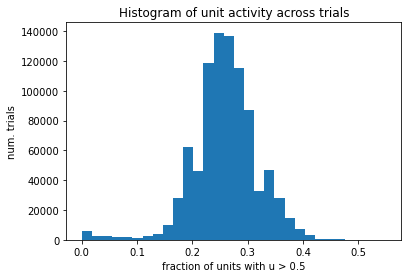

In [6]:
# Threshold above which cell is considered "active"
th = 0.5

# Compute fraction of cells at each time point that are active
pct_active = np.count_nonzero(np.abs(h) > th, axis=1) / 100

# Plot histogram of activity rates
plt.hist(pct_active, bins=30);
plt.title('Histogram of unit activity across trials')
plt.xlabel(f'fraction of units with u > {th}')
plt.ylabel('num. trials')